                            WLS Regression Results                            
Dep. Variable:                      x   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.438e+04
Date:                Tue, 12 Sep 2017   Prob (F-statistic):           1.35e-07
Time:                        14:57:48   Log-Likelihood:                -12.798
No. Observations:                   5   AIC:                             29.60
Df Residuals:                       3   BIC:                             28.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0333      3.865     -0.526      0.6

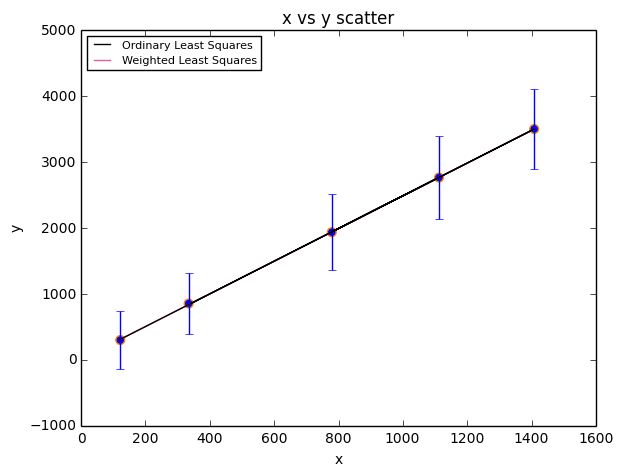

In [14]:
%matplotlib inline

from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

energy_list = [121.8, 1408, 778.9, 1112, 334.3,]
channel_list = [296.9, 3500, 1933, 2763, 850.9]
channel_err = np.array([4.470, 6.085, 5.795, 6.306, 4.654])

weights = 1/np.power(channel_err, 2)

# put x and y into a pandas DataFrame, and the weights into a Series
ws = pd.DataFrame({
    'x': energy_list,
    'y': channel_list,
    'yerr': map(lambda x: x * 100, channel_err)
})

wls_fit = sm.wls('x ~ y', data=ws, weights=1 / weights).fit()
ols_fit = sm.ols('x ~ y', data=ws).fit()

# show the fit summary by calling wls_fit.summary()

print(wls_fit.summary())

# let's plot our data
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')
ws.plot(
    kind='scatter',
    x='x',
    y='y',
    yerr='yerr',
    style='o',
    alpha=1.,
    ax=ax,
    title='x vs y scatter',
    edgecolor='#ff8300',
    s=40
)

# weighted prediction
wp, = ax.plot(
    wls_fit.predict(),
    ws['y'],
    color='#e55ea2',
    lw=1.,
    alpha=1.0,
)
# unweighted prediction
op, = ax.plot(  
    ols_fit.predict(),
    ws['y'],
    color='k',
    ls='solid',
    lw=1,
    alpha=1.0,
)
leg = plt.legend(
    (op, wp),
    ('Ordinary Least Squares', 'Weighted Least Squares'),
    loc='upper left',
    fontsize=8)

plt.tight_layout()
fig.set_size_inches(6.40, 5.12)
plt.savefig("so.png", dpi=100, alpha=True)
plt.show()

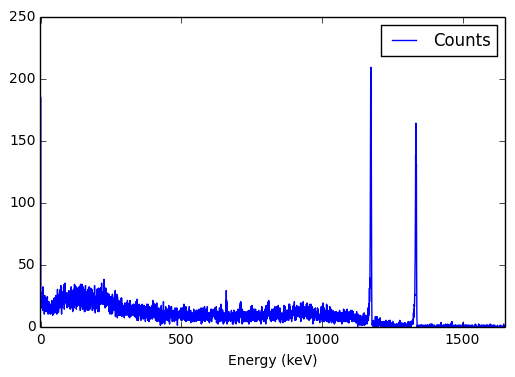

In [15]:
plt.figure(1)
co60 = pd.read_csv("data/co60.csv", names=['Channel','Counts'], header=0)
co60['Energy (keV)'] = co60['Channel'].apply(lambda x: x*wls_fit.params['y'] + wls_fit.params['Intercept'])
co60.plot(x='Energy (keV)', y='Counts')
plt.show()

In [16]:
co60_compton = co60.loc[(co60['Energy (keV)'] >= 1040) & (co60['Energy (keV)'] <=1096), ['Energy (keV)', 'Counts']]
compton_counts_mean = co60_compton.mean()['Counts']

7.71223021583
